# Kickstarter Projects 
### CSC 478 Final Project
#### Synopsis:
* The purpose of this project is to predict whether a kickstarter campaign will fail, succeed, or cancel based on the available information available [here](https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv).
* We will use an array of machine learning algorithms, including KNN, Linear Regression, Logistic Regression, and / or SVM to find the most accurate model.

#### Contributors:
* [Rebecca Tung (1448196)](https://github.com/rtungus)
* [Sidney Fox (1524992)](https://github.com/stfox13)

#### Data Dictionary:


##### Content
You'll find most useful data for project analysis. Columns are self explanatory except:

1. usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).

2. usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).

3. usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).


|Sequence Number|Column Name|Data Type|
|:---|:---|:---|
|1|ID|Numeric|
|2|name|String|
|3|category|String|
|4|main_category|String|
|5|currency|String|
|6|deadline|DateTime|
|7|goal|Numeric|
|8|launched|DateTime|
|9|pledged|Numeric|
|10|state|String|
|11|backers|Numeric|
|12|country|String|
|13|usd pledged|Numeric|
|14|usd_pledged_real|Numeric|
|15|usd_goal_real|Numeric|

## Libraries used through the project:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import plotly.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import os
import math
import requests
import datetime as dt
import matplotlib as mpl
import io
from pandas import Series, DataFrame
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import itertools
from sklearn.feature_selection import RFE
from collections import defaultdict

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Set graph size
mpl.rcParams['figure.figsize'] = (12,12)

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def roundup(x, y):
    #return int(math.ceil(x / float(y))) * y
    return int(math.ceil(x / y) * y)

## Load raw data as Pandas DataFrame:

In [6]:
url = 'https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv'
#url='ks-projects-201801.csv'
kickproj_org= pd.read_csv(url)
len(kickproj_org)

378661

## Define Reuseful Function

In [7]:
def roundup(x, y):
    #return int(math.ceil(x / float(y))) * y
    return int(math.ceil(float(x) / float(y)) * y)

In [8]:
#Define a fuction to print and plot confusin matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
#   print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
#Define a fuction to calculate and print TP, TN, FP, and FN for each category
def show_statistics(test_y, y_pred, matrix):
    TP = np.diag(matrix)
    FP = np.sum(matrix, axis=0) - TP
    FN = np.sum(matrix, axis=1) - TP
    TN = []
    for i in range(len(matrix)):
        temp = np.delete(matrix, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))    
    temp_dic = {'TP': TP, 'FP' : FP, 
                'TN' : TN, 'FN' : FN}
    scoreMatrix = DataFrame.from_dict(temp_dic)
    #print "TP, TN, FP, FN for each cateory: "
    return scoreMatrix

In [10]:
# Define a fuction to print F1 Score for each class and global (micro)
def formatResult(preResult, columnNames):  
    resultDF = DataFrame(preResult.values(), columns=columnNames, index=preResult.keys())
    resultDF.loc['sum'] = np.sum(preResult.values(), axis=0)
    resultDF['Sum of Class F1'] = np.append(np.sum(preResult.values(), axis=1), np.NaN)
    return resultDF

In [11]:
#######KNN############
#Define a function to run KNeighborsClassifier with different n_neighbors and store f1 score
def runKNN(trainX, trainY, testX, testY, number, f1_only = False, trainSetName = '', dic_result_knn = {}):
    i = 3
    cls = KNeighborsClassifier(n_neighbors=i)
    while i <= number:
        #print i
        cls = KNeighborsClassifier(n_neighbors=i)
        cls.fit(trainX, trainY)
        predY = cls.predict(testX)
        result = f1_score(testY, predY, average=None).round(2)
        result = np.append(result, f1_score(testY, predY, average='micro').round(2))
        
        #print results
        dic_result_knn['N=' + str(i) +'-' + trainSetName] = result
        #print "n_neighbors = " + str(i) + " : " + result
        i = i + 2
    return dic_result_knn

In [12]:
#######LogisticRegression############
# Define a function to run LogisticRegression with different class_weight settings and store f1 score
def runLogistic(trainX, trainY, testX, testY, f1_only = False, trainSetName = '', dic_result_log = {}):
    cls = LogisticRegression() 
    cls.fit(trainX, trainY)
    predY = cls.predict(testX)
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    dic_result_log['CWeight = None - ' + trainSetName] = result 
    
    cls = LogisticRegression(class_weight='balanced')
    cls.fit(trainX, trainY)
    predY = cls.predict(testX)
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    dic_result_log['CWeight = balanced - ' + trainSetName] = result   
    return dic_result_log

In [13]:
#######SVM############
# Define a function to run SVM with different kernel settings and store f1 score
def runSVM(trainX, trainY, testX, testY, f1_only = False, trainSetName = '', dic_result_log = {}):
    
    C = 1.0 # SVM regularization parameter
    svc = svm.SVC(kernel='linear', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    predY = svc.predict(X_plot)        
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    print results
    dic_result_log['SVCKernel = linear - ' + trainSetName] = result 
    
    svc = svm.SVC(kernel='rbf', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    predY = svc.predict(X_plot)        
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    print results
    dic_result_log['SVCKernel = rbf - ' + trainSetName] = result 
    
    #svc = svm.SVC(kernel='poly', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    #predY = svc.predict(X_plot)        
    #result = f1_score(testY, predY, average=None).round(2)
    #result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    #dic_result_log['SVCKernel = poly - ' + trainSetName] = result 
    
    return dic_result_log

## Check the Y data:

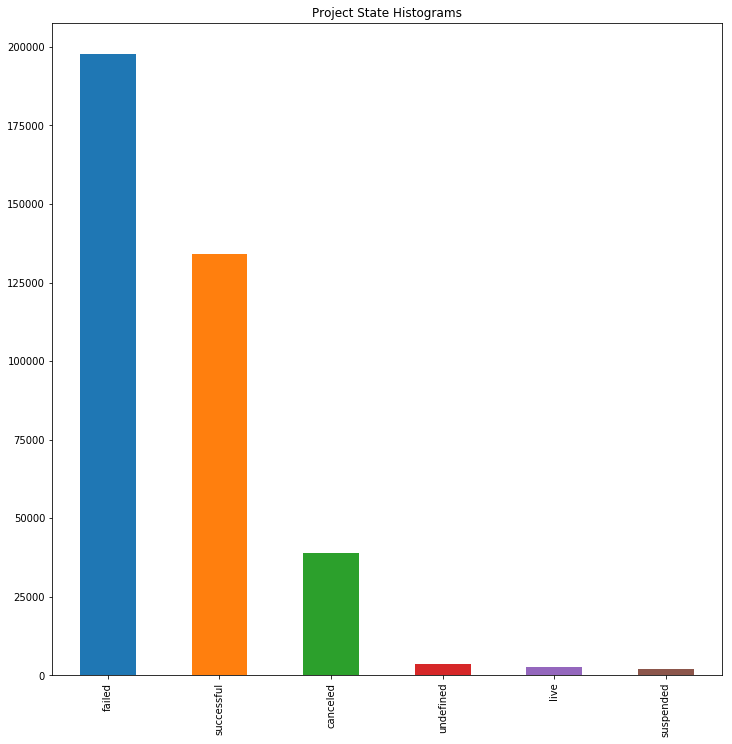

In [14]:
#Plot histogram
kickproj_org['state'].value_counts().plot(kind='bar', title='Project State Histograms')

### Drop projects when the state is equal to "undefined":

372300

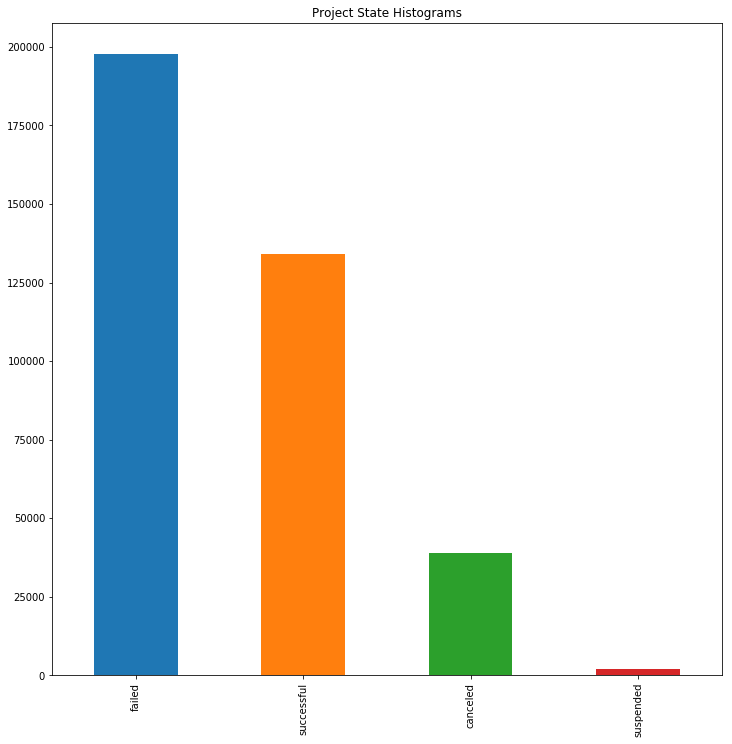

In [15]:
# Remove state = 'undefined'
kickproj = kickproj_org[(kickproj_org['state'] != 'undefined') & (kickproj_org['state'] != 'live')]
len(kickproj)
kickproj['state'].value_counts().plot(kind='bar', title='Project State Histograms')

In [16]:
kickproj.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### Since we have the goal and pledge amounts converted to US dollars (usd), we will drop the original goal and pledged columns:

In [17]:
#kickproj = kickproj[kickproj.columns.difference(['goal','pledged','usd pledged'])]
kickproj = kickproj.drop(['goal','pledged','usd pledged'], axis=1)
len(kickproj)
kickproj.head(5)

372300

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


## Check the X data:

In [18]:
kickproj.describe()

,ID,backers,usd_pledged_real,usd_goal_real
count,3.723000e+05,372300.000000,3.723000e+05,3.723000e+05
mean,1.074559e+09,106.910040,9.148405e+03,4.572162e+04
std,6.191804e+08,914.235813,9.170345e+04,1.151326e+06
min,5.971000e+03,0.000000,0.000000e+00,1.000000e-02
25%,5.378147e+08,2.000000,3.122000e+01,2.000000e+03
50%,1.075219e+09,12.000000,6.280000e+02,5.500000e+03
75%,1.610127e+09,57.000000,4.066000e+03,1.598542e+04
max,2.147476e+09,219382.000000,2.033899e+07,1.663614e+08


In [19]:
kickproj.corr()

,ID,backers,usd_pledged_real,usd_goal_real
ID,1.000000,0.000670,-0.000054,0.001814
backers,0.000670,1.000000,0.752478,0.004544
usd_pledged_real,-0.000054,0.752478,1.000000,0.005643
usd_goal_real,0.001814,0.004544,0.005643,1.000000


In [20]:
categoryDF = kickproj.groupby(['category']).size().reset_index(name='counts')
len(categoryDF)
categoryDF.head(5)

159

,category,counts
0,3D Printing,674
1,Academic,905
2,Accessories,3109
3,Action,733
4,Animals,252


,main_category,counts
0,Art,27959
1,Comics,10743
2,Crafts,8733
3,Dance,3749
4,Design,29763
5,Fashion,22563
6,Film & Video,62399
7,Food,24418
8,Games,34943
9,Journalism,4724


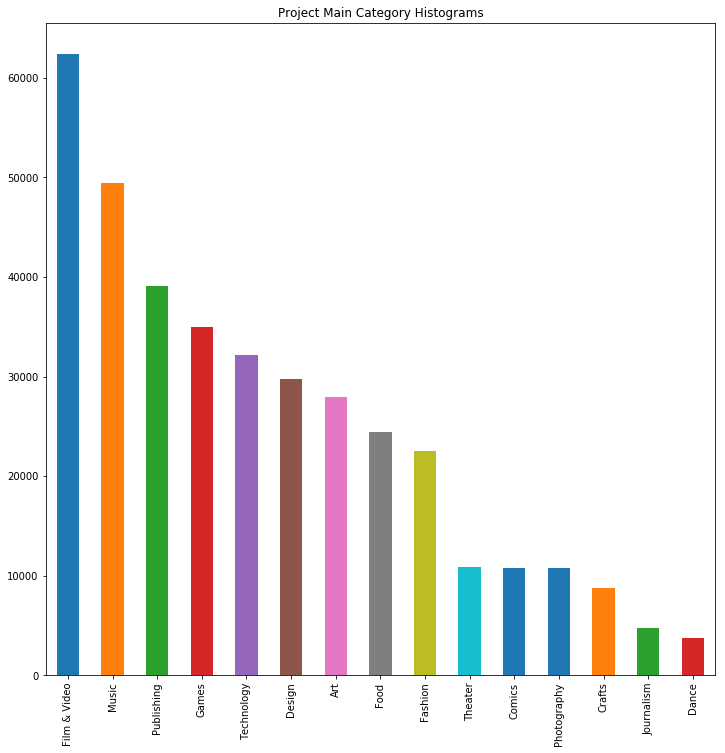

In [21]:
kickproj.groupby(['main_category']).size().reset_index(name='counts')
kickproj['main_category'].value_counts().plot(kind='bar', title='Project Main Category Histograms')

In [22]:
cateDF = kickproj.groupby(['main_category', 'category']).size().reset_index(name='counts')
len(cateDF)
cateDF.head(40)

170

,main_category,category,counts
0,Art,Art,8190
1,Art,Ceramics,302
2,Art,Conceptual Art,1022
3,Art,Digital Art,1331
4,Art,Illustration,3134
5,Art,Installations,475
6,Art,Mixed Media,2738
7,Art,Painting,3275
8,Art,Performance Art,2150
9,Art,Public Art,3070


,country,counts
0,AT,582
1,AU,7769
2,BE,605
3,CA,14624
4,CH,747
5,DE,4096
6,DK,1097
7,ES,2224
8,FR,2887
9,GB,33393


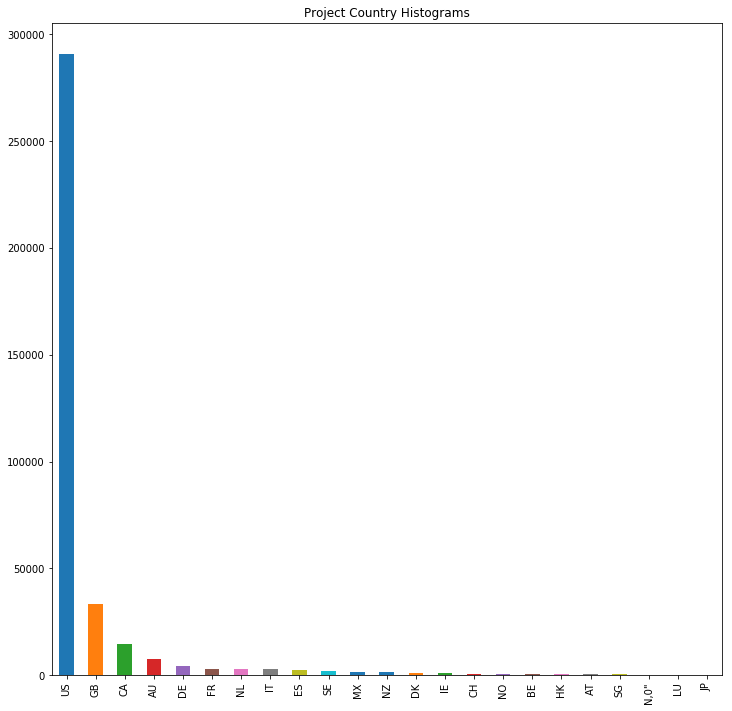

In [23]:
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Remove country with invalid value, N,0"

,country,counts
0,AT,582
1,AU,7769
2,BE,605
3,CA,14624
4,CH,747
5,DE,4096
6,DK,1097
7,ES,2224
8,FR,2887
9,GB,33393


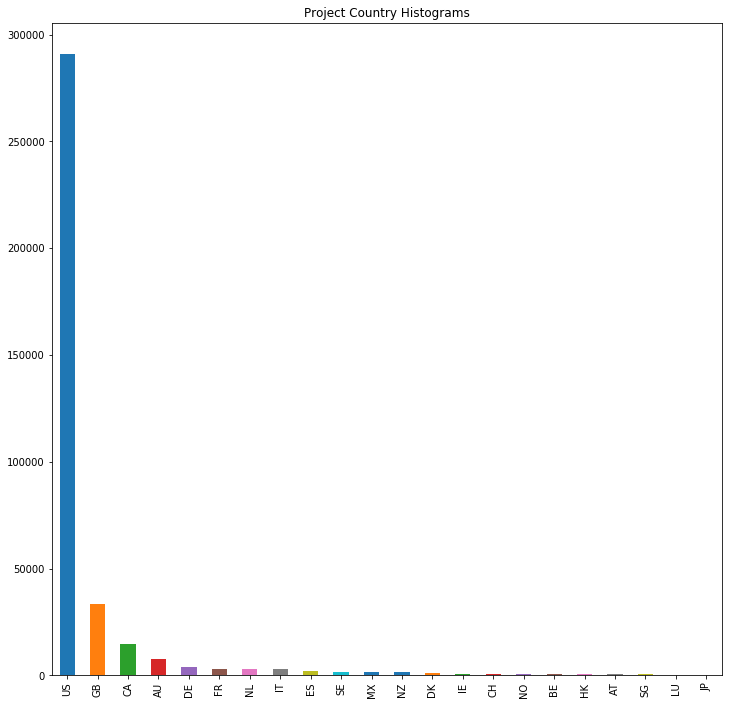

In [24]:
kickproj = kickproj[kickproj['country'] != 'N,0"']
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Check null value 

In [25]:
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns
kickproj[null_columns].isnull().sum()
kickproj[kickproj["name"].isnull()][null_columns] 

Index([u'name'], dtype='object')

name    4
dtype: int64

,name
166851,NaN
307234,NaN
309991,NaN
338931,NaN


### Replace nan with Unknow for name

In [26]:
kickproj["name"].fillna('Unknown', inplace=True)
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns

Index([], dtype='object')

### Apply correct data types to DataFrame:

In [27]:
print 'Data types do not align with the data types defined in the data dictionary:\n\n', kickproj.dtypes

Data types do not align with the data types defined in the data dictionary:

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object


In [28]:
# Columns that are of date data type:
datecols = ['deadline','launched']
# Columns that are of int data type:
intcols = ['usd_pledged_real','usd_goal_real']

for col in datecols:
    kickproj[col] = pd.to_datetime(kickproj[col])
    kickproj[col] = [d.date().toordinal() for d in kickproj[col]]

kickproj[intcols] = kickproj[intcols].fillna(0).astype(np.int64)
kickproj['duration'] = abs(kickproj['deadline']-kickproj['launched'])

In [29]:
print 'Review converted data types:\n\n', kickproj.dtypes

Review converted data types:

ID                   int64
name                object
category            object
main_category       object
currency            object
deadline             int64
launched             int64
state               object
backers              int64
country             object
usd_pledged_real     int64
usd_goal_real        int64
duration             int64
dtype: object


### Find out correlation among variables
1. ** Feature X - backer (0.33), duration (0.11), usd_pledged_real(0.45), usd_goal_real (-0.07), currency (-0.05) and country (-0.04) are strongly correlated with State (Target Variable) **
2. ** Currency and Country are highly correlated (0.94).  Only one should be used in the model.  We decide to go with Country **
3. ** Duration is derived from deadline and launched.  Duration will be used instead of deadline and launched in the model.**

In [30]:
kickproj.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration
ID,1.000000,0.991702,-0.001266,0.003227,-0.000461,0.010542,0.010580,-0.003325,0.025534,-0.000714,0.122894,0.101211,-0.002766
name,0.991702,1.000000,-0.001798,0.004790,-0.000130,0.010622,0.010403,-0.003056,0.026620,-0.000379,0.123884,0.100289,-0.002516
category,-0.001266,-0.001798,1.000000,0.239782,0.037822,-0.056483,-0.052595,-0.024760,-0.057384,0.037786,-0.067791,0.031354,-0.017923
main_category,0.003227,0.004790,0.239782,1.000000,0.075106,-0.039784,-0.047838,-0.028576,0.027066,0.076710,0.010796,0.071892,-0.014940
currency,-0.000461,-0.000130,0.037822,0.075106,1.000000,-0.021692,-0.021845,-0.045832,-0.011019,0.944500,-0.002854,0.348965,-0.024466
deadline,0.010542,0.010622,-0.056483,-0.039784,-0.021692,1.000000,0.304547,0.035392,-0.005645,-0.022703,0.001208,-0.034246,0.078976
launched,0.010580,0.010403,-0.052595,-0.047838,-0.021845,0.304547,1.000000,0.030601,-0.019064,-0.023052,-0.011738,-0.033243,0.079399
state,-0.003325,-0.003056,-0.024760,-0.028576,-0.045832,0.035392,0.030601,1.000000,0.331426,-0.041640,0.450139,-0.071894,0.110521
backers,0.025534,0.026620,-0.057384,0.027066,-0.011019,-0.005645,-0.019064,0.331426,1.000000,-0.010042,0.567818,0.009474,0.023029
country,-0.000714,-0.000379,0.037786,0.076710,0.944500,-0.022703,-0.023052,-0.041640,-0.010042,1.000000,0.001240,0.346439,-0.022561


Heat Map of Correlation Coefficients:


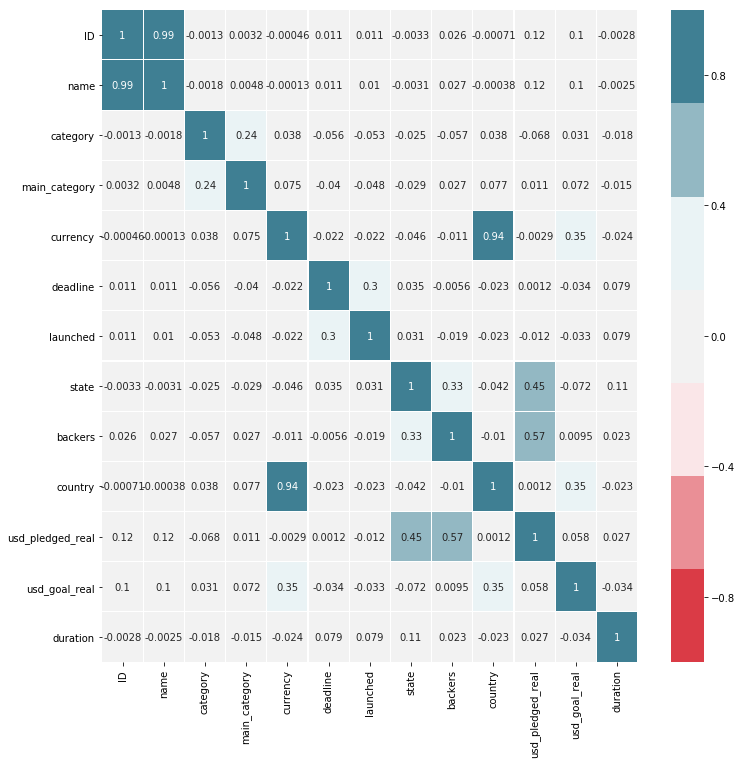

In [31]:
print('Heat Map of Correlation Coefficients:')
sns.heatmap(kickproj.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), cmap=sns.diverging_palette(10, 220, sep=80, n=7), linewidths=0.1, annot=True, vmin=-1, vmax=1)

### Check the range of usd_pledged_real and usd_goal_real

In [32]:
binrange = range(1, roundup(max(kickproj['usd_pledged_real']),100000), 5000000)
binrange

[1, 5000001, 10000001, 15000001, 20000001]

In [33]:
min(kickproj['usd_goal_real'])
max(kickproj['usd_goal_real'])

0L

166361390L

In [34]:
min(kickproj['usd_pledged_real'])
max(kickproj['usd_pledged_real'])

0L

20338986L

### Check whether All successful records have usd_pledged_real > 0 - Outliners to be removed

In [35]:
# All successful records have usd_pledged_real > 0? - There is one record with excpetion and we remove it
min(kickproj['usd_pledged_real'])
x = kickproj[(kickproj['usd_pledged_real']==0) & (kickproj['state']=='successful')].index
kickproj.drop(x, inplace=True)
kickproj[(kickproj['usd_pledged_real']==0) & (kickproj['state']=='successful')]

0L

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration


#### Create Projects Summary DataFrame:

kickproj_summary = kickproj.groupby(['main_category','state'], as_index=False) \
[['usd_goal_real','usd_pledged_real','backers']].agg({
    'usd_goal_real':[np.sum, np.mean, np.std],
    'usd_pledged_real':[np.sum, np.mean, np.std],
    'backers':[np.sum, np.mean, np.std,'count']
})

#"Flatten" summary results:
kickproj_summary.columns = list(map('_'.join, kickproj_summary.columns.values))

#Rename a few columns:
kickproj_summary.columns.values[-1] = 'project_count'
kickproj_summary.columns.values[0] = 'main_category'
kickproj_summary.columns.values[1] = 'state'

kickproj_summary.head()

#### Data Visualization

from ggplot import *

ggplot(kickproj, aes(x='backers', y='usd_pledged_real', color='state')) +\
    geom_point(size=20) +\
    xlab('backers') + ylab('usd_pledged_real') + ggtitle('Backers v. Pledged\nFaceted by Project State') +\
    scale_x_continuous(limits=(0,max(kickproj.backers))) +\
    scale_y_continuous(limits=(0,max(kickproj.usd_pledged_real))) +\
    theme_bw() +\
    facet_grid('state')    

fig=plt.figure(figsize=(16, 16), dpi= 100, facecolor='w', edgecolor='k')

ggplot(kickproj[(kickproj['state'] =='successful')], aes(x='backers', y='usd_pledged_real', color='state')) +\
    geom_point(size=20) +\
    xlab('backers') + ylab('usd_pledged_real') + ggtitle('Backers v. Pledged\nState is equal to Successful') +\
    scale_x_continuous(limits=(0,150000),labels='comma') +\
    scale_y_continuous(limits=(0,max(kickproj.usd_pledged_real)),labels='comma') +\
    theme_bw() 

### Shuffle the dataset and create training and test datasets

In [49]:
shffled_kickproj = kickproj.sample(frac=1)

#### Convert the value of state to True (success) or False (Other)

In [50]:
shffled_kickproj['state_cd'] = shffled_kickproj['state'].apply(lambda a: True if a == 'successful' else False)
shffled_kickproj.head(5)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration,state_cd
28294,1143510550,"Get ""Fractured"" to CMF Hollywood!",Shorts,Film & Video,USD,735678,735648,failed,3,US,100,2000,30,False
58613,1298096066,The Transformation of Jesse aka Jesse's Journe...,Shorts,Film & Video,USD,735018,734988,canceled,4,US,120,12500,30,False
201499,2026201063,Unity Multitouch Table,Technology,Technology,USD,734528,734498,failed,5,US,106,65000,30,False
337263,787882107,Instuctional video Guitar Building Step by Step,Illustration,Art,USD,734826,734796,failed,1,US,100,2000,30,False
114892,1583525762,Boone at BRAC,Architecture,Design,USD,736202,736172,failed,21,US,2365,21000,30,False


#### Convert each country to a number

In [51]:
le = preprocessing.LabelEncoder()
le.fit(shffled_kickproj['country'])
shffled_kickproj['country_cd'] = le.transform(shffled_kickproj['country'])
shffled_kickproj.head(5)

LabelEncoder()

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,duration,state_cd,country_cd
28294,1143510550,"Get ""Fractured"" to CMF Hollywood!",Shorts,Film & Video,USD,735678,735648,failed,3,US,100,2000,30,False,21
58613,1298096066,The Transformation of Jesse aka Jesse's Journe...,Shorts,Film & Video,USD,735018,734988,canceled,4,US,120,12500,30,False,21
201499,2026201063,Unity Multitouch Table,Technology,Technology,USD,734528,734498,failed,5,US,106,65000,30,False,21
337263,787882107,Instuctional video Guitar Building Step by Step,Illustration,Art,USD,734826,734796,failed,1,US,100,2000,30,False,21
114892,1583525762,Boone at BRAC,Architecture,Design,USD,736202,736172,failed,21,US,2365,21000,30,False,21


In [57]:
num = shffled_kickproj.shape[0]/2

fi_vals, train_x, train_y = shffled_kickproj.iloc[0:num, [1,2,3,4,5,6,7,8,9,10,11,12,13,14]], shffled_kickproj.iloc[0:num, [8,9,10,11,12,14]], shffled_kickproj.iloc[0:num, 13]
test_x, test_y = shffled_kickproj.iloc[num:, [8,9,10,11,12,14]], shffled_kickproj.iloc[num:, 13]
train_x.head(2)
train_x.shape
train_y.head(2)
train_y.shape
test_x.head(2)
test_x.shape
test_y.head(2)
test_y.shape

,backers,country,usd_pledged_real,usd_goal_real,duration,country_cd
28294,3,US,100,2000,30,21
58613,4,US,120,12500,30,21


(186032, 6)

28294    False
58613    False
Name: state_cd, dtype: bool

(186032,)

,backers,country,usd_pledged_real,usd_goal_real,duration,country_cd
257450,22,US,652,1000,60,21
353444,16,US,1101,36000,30,21


(186033, 6)

257450    False
353444    False
Name: state_cd, dtype: bool

(186033,)

### Train training set
#### Convert country using oneHotEncoder

In [50]:
temp_features_train = train_x['country_cd'].reshape(-1, 1) # Needs to be the correct shape
temp_features_test = test_x['country_cd'].reshape(-1, 1) # Needs to be the correct shape

/Users/rebeccatung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/rebeccatung/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [51]:
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
#fit on training set only
ohe.fit(temp_features_train)
countryDF_train = DataFrame(ohe.transform(temp_features_train), columns = ohe.active_features_, index = train_x.index)
countryDF_test = DataFrame(ohe.transform(temp_features_test), columns = ohe.active_features_, index = test_x.index)
countryDF_train.head(10)
countryDF_test.head(10)

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
223428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
275183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
221428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
138523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
256966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
56235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
297256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
364939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
260470,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
302490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
226441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
train_x.shape
countryDF_train.shape
test_x.shape
countryDF_test.shape

(186032, 6)

(186032, 22)

(186033, 6)

(186033, 22)

In [53]:
train_X1 = pd.merge(train_x.drop(['country','country_cd'], axis=1), countryDF_train, left_index=True, right_index=True)
train_X1.head(10)
train_X1.shape

test_X1 = pd.merge(test_x.drop(['country','country_cd'], axis=1), countryDF_test, left_index=True, right_index=True)
test_X1.head(10)
test_X1.shape

,backers,usd_pledged_real,usd_goal_real,duration,0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
223428,93,21487,20000,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98090,107,7116,6000,60,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231006,30,3965,2630,36,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,88,9260,8000,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
275183,0,0,10000,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
221428,0,0,10000,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
138523,0,0,3000,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
256966,1,10,500,60,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
56235,11,95,4680,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
297256,8,410,160000,60,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(186032, 26)

,backers,usd_pledged_real,usd_goal_real,duration,0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
364939,3,12,35000,45,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
260470,0,0,201,30,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17335,31,3115,3000,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
224154,437,92867,215000,31,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
46847,2,80,371,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
302490,6,61,1042,30,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163815,1,10,1000,59,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41436,2,2,20000,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
226441,5,488,4500,50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17263,25,3295,10000,30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(186033, 26)

In [54]:
result_Dic = {}
#Call function to run KNeighborsClassifier with different n_neighbors settings (up to 20) and store the f1 score results
result_Dic = runKNN(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), 18, trainSetName = 'Basic&Country', dic_result_knn = result_Dic)

In [55]:
#Call function to run LogisticRegression with different class_weight settings (None or Balance)  and store the f1 score results
result_Dic = runLogistic(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), trainSetName = 'Basic&Country', dic_result_log = result_Dic)

In [56]:
# Call function to run LogisticSVM with different kernel settings (linear, rbf or poly)  and store the f1 score results
# result_Dic = runSVM(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), trainSetName = 'Basic&Country', dic_result_log = result_Dic)

In [57]:
#Store number of classes
n_classes = np.unique(shffled_kickproj['state_cd'])
n_classes
resultDF = formatResult(result_Dic, np.append(n_classes, 'micro'))
resultDF.head(10)

array([False,  True], dtype=bool)

,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.00,1.00,1.00,3.00
N=15-Basic&Country,1.00,0.99,1.00,2.99
N=11-Basic&Country,1.00,1.00,1.00,3.00
N=13-Basic&Country,1.00,0.99,1.00,2.99
N=3-Basic&Country,1.00,1.00,1.00,3.00
N=17-Basic&Country,1.00,0.99,1.00,2.99
CWeight = None - Basic&Country,0.99,0.99,0.99,2.97
N=7-Basic&Country,1.00,1.00,1.00,3.00
CWeight = balanced - Basic&Country,0.98,0.96,0.97,2.91
N=9-Basic&Country,1.00,1.00,1.00,3.00


In [58]:
# Print out the top 10 Micro (overall) F1 score from all settings
resultDF.drop('sum').nlargest(5, 'micro')
resultDF.drop('sum').nlargest(5, 'Sum of Class F1')

,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.0,1.00,1.0,3.00
N=15-Basic&Country,1.0,0.99,1.0,2.99
N=11-Basic&Country,1.0,1.00,1.0,3.00
N=13-Basic&Country,1.0,0.99,1.0,2.99
N=3-Basic&Country,1.0,1.00,1.0,3.00


,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.0,1.0,1.0,3.0
N=11-Basic&Country,1.0,1.0,1.0,3.0
N=3-Basic&Country,1.0,1.0,1.0,3.0
N=7-Basic&Country,1.0,1.0,1.0,3.0
N=9-Basic&Country,1.0,1.0,1.0,3.0


In [59]:
knnClr = KNeighborsClassifier(n_neighbors=5)
knnClr.fit(train_X1, train_y.values.ravel())
final_y_pred = knnClr.predict(test_X1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

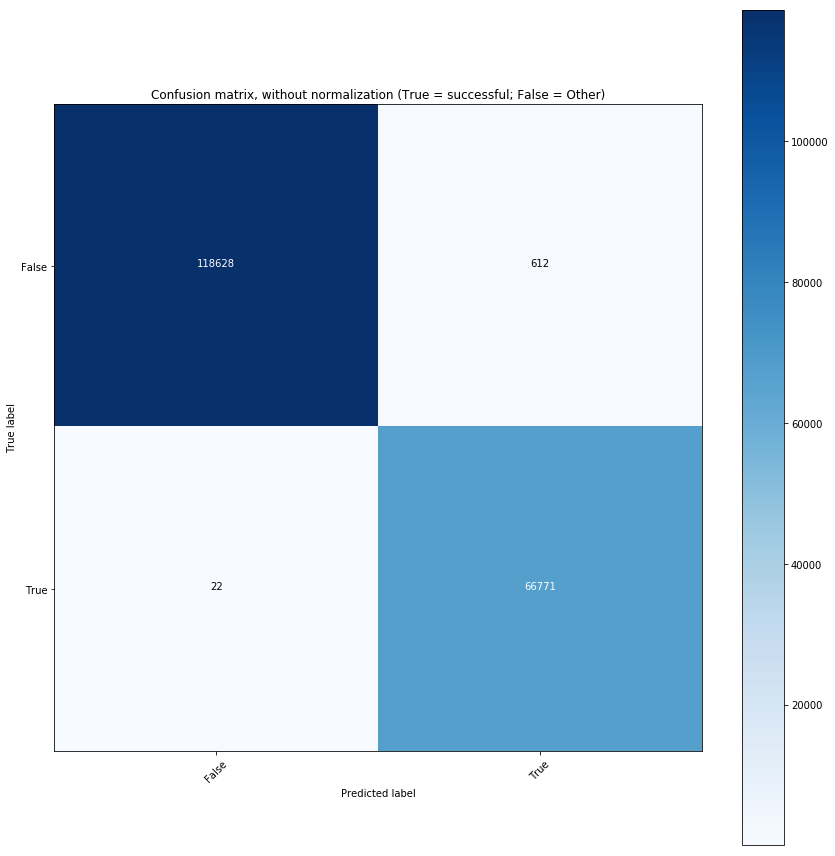

In [60]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, final_y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[False,True],
                      normalize=False,
                      title='Confusion matrix, without normalization (True = successful; False = Other)')

In [61]:
stats = show_statistics(test_y, final_y_pred, cnf_matrix)
strName = map((lambda a: 'successful' if a == True else 'Failed/Cancelled/Live/Suspended'),  [False, True])
print "Classificaiton Reprt:"
print classification_report(test_y, final_y_pred, target_names=strName, digits=2)

Classificaiton Reprt:
                                 precision    recall  f1-score   support

Failed/Cancelled/Live/Suspended       1.00      0.99      1.00    119240
                     successful       0.99      1.00      1.00     66793

                    avg / total       1.00      1.00      1.00    186033



# Feature Importance


In [84]:
#Encode non-numeric variables - needed to run most of the models, understand anything feature importance:
le = preprocessing.LabelEncoder
d = defaultdict(le)
le_df = fi_vals.drop(
    ['currency','deadline','launched','country','state'], axis=1).apply(
    lambda x: d[x.name].fit_transform(x))

In [85]:
le_features, le_target = le_df[le_df.columns.drop('state_cd')], le_df['state_cd']

In [86]:
#We'll look at recursive feature elimination   (RFE) with logistic regression and select three features:
LogReg_RFE = RFE(LogisticRegression(), 3).fit(le_features, le_target)
print('The three most important features according to Logistic Regression:\n'),(np.array(le_features.columns)[LogReg_RFE.support_])

In [89]:
#We'll look at recursive feature elimination (RFE) with linear regression and select three features:
LinReg_RFE = RFE(LinearRegression(), 3).fit(le_features, le_target)
print('The three most important features according to Linear Regression:\n'),(np.array(le_features.columns)[LinReg_RFE.support_])

Column Names and Associated Feature Importance:


,Feature Importance
Columns,
name,0.020201
category,0.019057
main_category,0.026403
backers,0.168905
usd_pledged_real,0.489028
usd_goal_real,0.243059
duration,0.024777
country_cd,0.008571


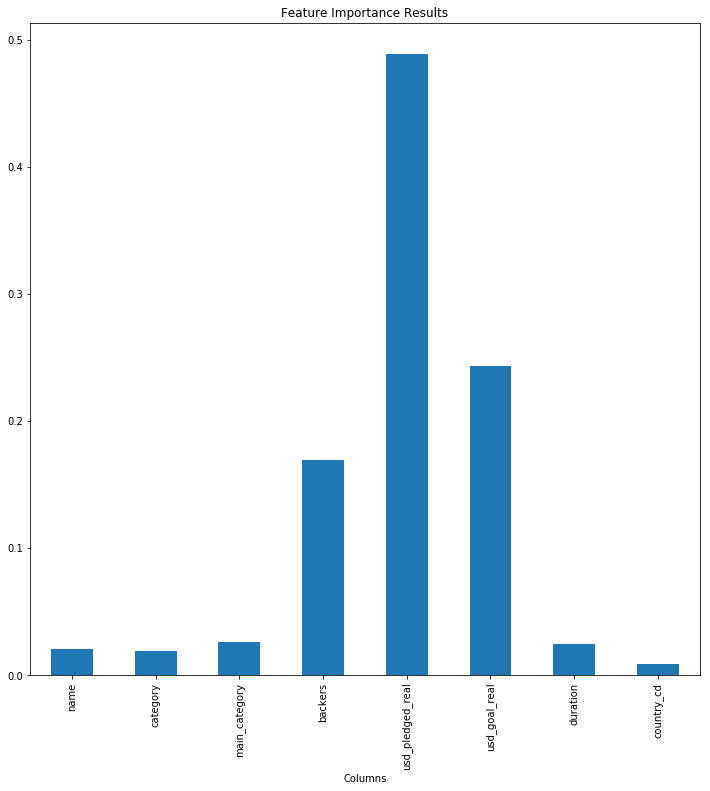

In [93]:
#We'll use extra trees classifier to calculate feature importance:
ETC = ExtraTreesClassifier().fit(le_features, le_target)
feat_imp_df = pd.DataFrame({'Columns':pd.Series(le_features.columns)})
feat_imp_df['Feature Importance'] = pd.Series(ETC.feature_importances_)
feat_imp_df.set_index(['Columns'],inplace=True)
print('Column Names and Associated Feature Importance:')
feat_imp_df
feat_imp_df.plot(kind="bar", title="Feature Importance Results", legend = False)

In [97]:
temp_features_fi = fi_vals['country_cd'].reshape(-1, 1) # Needs to be the correct shape
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
ohe.fit(temp_features_fi)
countryDF_fi = DataFrame(ohe.transform(temp_features_fi), 
                            columns = ohe.active_features_, index = fi_vals.index)


/Users/sidneyfox/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [100]:
fi_vals_ohe = pd.merge(fi_vals.drop(['country','country_cd'], axis=1), countryDF_fi, left_index=True, right_index=True)
fi_vals_ohe

,name,category,main_category,currency,deadline,launched,state,backers,usd_pledged_real,usd_goal_real,...,12,13,14,15,16,17,18,19,20,21
28294,"Get ""Fractured"" to CMF Hollywood!",Shorts,Film & Video,USD,735678,735648,failed,3,100,2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58613,The Transformation of Jesse aka Jesse's Journe...,Shorts,Film & Video,USD,735018,734988,canceled,4,120,12500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
201499,Unity Multitouch Table,Technology,Technology,USD,734528,734498,failed,5,106,65000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
337263,Instuctional video Guitar Building Step by Step,Illustration,Art,USD,734826,734796,failed,1,100,2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
114892,Boone at BRAC,Architecture,Design,USD,736202,736172,failed,21,2365,21000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
298420,DogBox - Safe & Comfy Travel For Your Canine F...,Product Design,Design,GBP,736141,736111,failed,0,0,13282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317979,Love and hate at the end of the world a novel,Fiction,Publishing,USD,734792,734737,failed,2,3,2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112304,Wrath,Video Games,Games,USD,736295,736265,failed,3,60,2000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
104606,La Muerte de Rafael Rivera,Film & Video,Film & Video,MXN,736651,736591,successful,28,3804,3760,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
161047,The DeadEnders,Webseries,Film & Video,USD,735242,735197,failed,15,951,10000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [103]:
ohe_df = fi_vals_ohe.drop(
    ['currency','deadline','launched','state'], axis=1).apply(
    lambda x: d[x.name].fit_transform(x))

In [104]:
ohe_features, ohe_target = ohe_df[ohe_df.columns.drop('state_cd')], ohe_df['state_cd']

In [105]:
#We'll look at recursive feature elimination   (RFE) with logistic regression and select three features:
LogReg_RFE = RFE(LogisticRegression(), 3).fit(ohe_features, ohe_target)
print('The three most important features according to Logistic Regression:\n'),(np.array(ohe_features.columns)[LogReg_RFE.support_])

The three most important features according to Logistic Regression:
['backers' 'duration' 21]


In [106]:
#We'll look at recursive feature elimination (RFE) with linear regression and select three features:
LinReg_RFE = RFE(LinearRegression(), 3).fit(ohe_features, ohe_target)
print('The three most important features according to Linear Regression:\n'),(np.array(ohe_features.columns)[LinReg_RFE.support_])

The three most important features according to Linear Regression:
[9 10 21]


Column Names and Associated Feature Importance:


,Feature Importance
Columns,
name,0.026301
category,0.023691
main_category,0.025416
backers,0.204942
usd_pledged_real,0.477288
usd_goal_real,0.205789
duration,0.026766
0,0.000141
1,0.000693


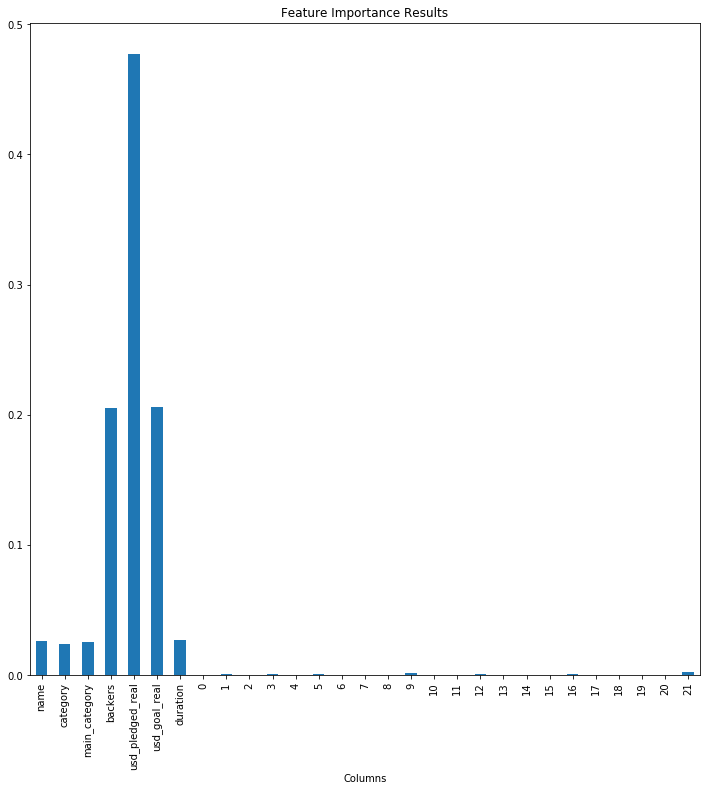

In [107]:
#We'll use extra trees classifier to calculate feature importance:
ETC = ExtraTreesClassifier().fit(ohe_features, ohe_target)
feat_imp_df = pd.DataFrame({'Columns':pd.Series(ohe_features.columns)})
feat_imp_df['Feature Importance'] = pd.Series(ETC.feature_importances_)
feat_imp_df.set_index(['Columns'],inplace=True)
print('Column Names and Associated Feature Importance:')
feat_imp_df
feat_imp_df.plot(kind="bar", title="Feature Importance Results", legend = False)